# Supporting Code for Saccharide concentration prediction from proxy ocean samples analyzed via infrared spectroscopy and quantitative machine learning.

#### Code authored by Nicole North and Abigail Enders

#### Gradient Boosted Regression

In [1]:
#Data Import and Visualization
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math

#Machine Learning Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML Model
from sklearn.ensemble import GradientBoostingRegressor

#Model and Data Analysis
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

First we bring in all of our data.

In [2]:
path = r'C:\Users\north.154\OneDrive - The Ohio State University\Desktop\Current Work\Papers\Saccharide Quantification Paper\Files for GitHub'
#Training Dataset and data for lab Proxies
filename = 'trainingSpectra.csv'
op_filename = 'unknowns_subset.csv'
#List of Concentrations for the Training Set
conc = 'conc.csv'

#Read in data into dataframes
os.chdir(path)
df = pd.read_csv(filename, index_col=False)
op_df = pd.read_csv(op_filename, index_col=False)
concs = pd.read_csv(conc, index_col=False)

Each of our samples was taken in triplicate so we will need to correct the list 

In [3]:
conc_unknown = [0.2002,0.2002,0.2002,0.1502,0.1502,0.1502,0.1001,0.1001,0.1001] #Saccharide Concentration of Lab Proxies


#make list of concentrations (triplicate measurements)
conc_list = list(concs.iloc[:, 0])
conc_l2 = []
c = 0
for i in conc_list:
    while c < 3:
        conc_l2.append(i)
        c += 1
    c = 0
conc = pd.DataFrame(conc_l2)


#set up spectra data
wavenumbers = df.iloc[0]
data = df.iloc[0:, 1:]
data = data.iloc[300:900,:]

op_data = op_df.iloc[300:900,:]

Plot the Experimental Data for Reference

Text(0, 0.5, 'Absorbance (arb. units)')

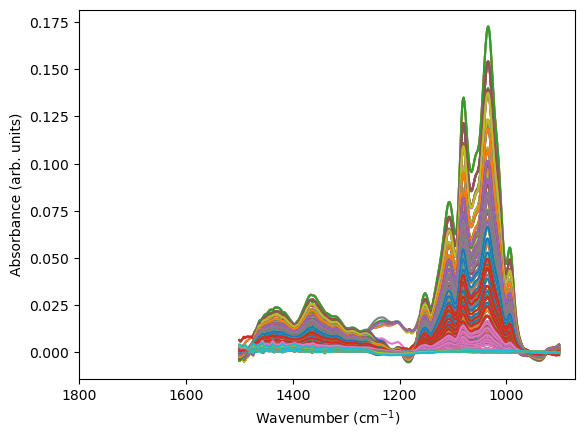

In [4]:
plt.plot(data)
plt.xticks([0,200,400,600,800],[1800,1600,1400,1200,1000])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Absorbance (arb. units)')

We can now standardize the dataset using the Sklearn StandardScaler Function

StandardScaler subtracts the mean from each sample and divides by the standard deviation

In [5]:
# scale data 
sc_X = StandardScaler()
sc_y = StandardScaler()

# transpose data so rows are wavenumbers
X = np.transpose(data)
X_unknown = np.transpose(op_data)

# use scaler on x,y data
sc_X.fit(X)
X = sc_X.transform(X.values.astype(float))
X_unknown = sc_X.transform(X_unknown.values.astype(float))

y = conc

Now we can split our data into train and testing sets.

In [6]:
# train test data split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=0.5, random_state=42)

Train Model on Train Test Split Data

In [7]:
# initialize regressor & fit
regressor = GradientBoostingRegressor(loss = 'huber',n_estimators=2000, learning_rate=0.5, max_depth=1, random_state=42)
regressor.fit(X_train,y_train)

y_calibrate_pred = regressor.predict(X_train) #Final Training Results
y_val_pred = regressor.predict(X_validate) # Final Testing Results
y_test_pred = regressor.predict(X_test)
y_un_pred = regressor.predict(X_unknown) # predict on new data

C:\Users\north.154\AppData\Local\anaconda3_1\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# print mean sq. err
print("*GBR Model Statistics*")
print('R Squared Score: %4f' % metrics.r2_score(y_validate, y_val_pred))
print('________________________________________________________________')
print("-Errors from Calibration-")
print('RMSE: %.4f' % math.sqrt(mean_squared_error(y_train, y_calibrate_pred, squared = True)) + ' M')
print('Mean Absolute Error: %4f' % metrics.mean_absolute_error(y_train, y_calibrate_pred) + ' M')
print('________________________________________________________________')
print("-Errors from Validation Data-")
print('RMSE: %.4f' % math.sqrt(mean_squared_error(y_validate, y_val_pred, squared = True)) + ' M')
print('Mean Absolute Error: %4f' % metrics.mean_absolute_error(y_validate, y_val_pred) + ' M')
print('________________________________________________________________')
print("-Errors from Test Data-")
print('RMSE: %.4f' % math.sqrt(mean_squared_error(y_test, y_test_pred, squared = True)) + ' M')
print('Mean Absolute Error: %4f' % metrics.mean_absolute_error(y_test, y_test_pred) + ' M')


*GBR Model Statistics*
R Squared Score: 0.986514
________________________________________________________________
-Errors from Calibration-
RMSE: 0.0021 M
Mean Absolute Error: 0.000499 M
________________________________________________________________
-Errors from Validation Data-
RMSE: 0.0259 M
Mean Absolute Error: 0.016133 M
________________________________________________________________
-Errors from Test Data-
RMSE: 0.0398 M
Mean Absolute Error: 0.024370 M


In [9]:
y_un_pred = pd.DataFrame(y_un_pred).T


sample_a = (y_un_pred[0] + y_un_pred[1] + y_un_pred[2])/3
print("Sample A Actual Conc:          0.2002 M")
print("Sample A GBR Predicted Conc:  "+ str(sample_a.values)+ ' M')
print("Sample A Difference:          " + str(0.2002 - sample_a.values)+ ' M')
print("Sample A Percentage:          " + str((sample_a.values /0.2002)*100)+ ' M')
print("_______________________________________________________")

sample_b = (y_un_pred[3] + y_un_pred[4] + y_un_pred[5])/3
print("Sample B Actual Conc:          0.1502 M")
print("Sample B GBR Predicted Conc:  "+ str(sample_b.values)+ ' M')
print("Sample B Difference:          " + str(0.1502 - sample_b.values)+ ' M')
print("Sample B Percentage:          " + str((sample_b.values /0.1502)*100)+ ' M')
print("_______________________________________________________")

sample_c = (y_un_pred[6] + y_un_pred[7] + y_un_pred[8])/3
print("Sample C Actual Conc:          0.1001 M")
print("Sample C GBR Predicted Conc:  "+ str(sample_c.values)+ ' M')
print("Sample C Difference:          " + str(0.1001 - sample_c.values)+ ' M')
print("Sample C Percentage:          " + str((sample_c.values /0.100)*100)+ ' M')



Sample A Actual Conc:          0.2002 M
Sample A GBR Predicted Conc:  [0.14038448] M
Sample A Difference:          [0.05981552] M
Sample A Percentage:          [70.12211621] M
_______________________________________________________
Sample B Actual Conc:          0.1502 M
Sample B GBR Predicted Conc:  [0.14575869] M
Sample B Difference:          [0.00444131] M
Sample B Percentage:          [97.04306695] M
_______________________________________________________
Sample C Actual Conc:          0.1001 M
Sample C GBR Predicted Conc:  [0.11872617] M
Sample C Difference:          [-0.01862617] M
Sample C Percentage:          [118.72616747] M


In [10]:
val_results = pd.DataFrame(y_validate)
val_results.columns = (['Actual Validation Concentration'])
val_results['SVR Validation Concentrations'] = y_val_pred
val_results['Difference'] = val_results['Actual Validation Concentration'] - val_results['SVR Validation Concentrations']
val_results['Abs Difference %'] = (val_results['Difference'].abs())/val_results['Actual Validation Concentration']

In [11]:
test_results = pd.DataFrame(y_test)
test_results.columns = (['Actual Test Concentration'])
test_results['SVR Test Concentrations'] = y_test_pred
test_results['Difference'] = test_results['Actual Test Concentration'] - test_results['SVR Test Concentrations']
test_results['Abs Difference %'] = (test_results['Difference'].abs())/test_results['Actual Test Concentration']

(-0.3, 0.3)

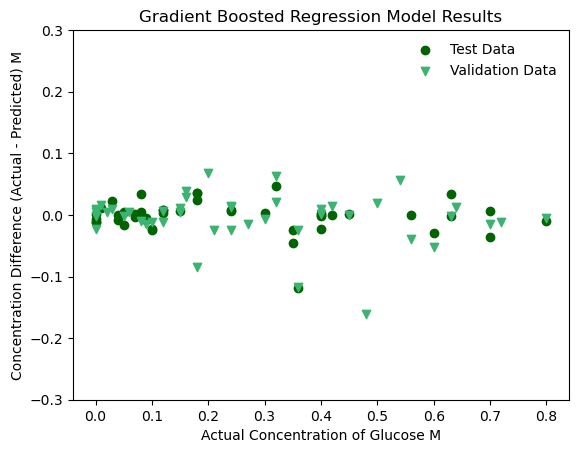

In [12]:
plt.scatter(val_results['Actual Validation Concentration'], val_results['Difference'], marker = 'o', color = 'darkgreen', label ='Test Data' )
plt.scatter(test_results['Actual Test Concentration'], test_results['Difference'], marker = 'v', color = 'mediumseagreen', label = 'Validation Data' )
plt.legend(frameon = False)
plt.title('Gradient Boosted Regression Model Results')
plt.ylabel('Concentration Difference (Actual - Predicted) M')
plt.xlabel('Actual Concentration of Glucose M')
plt.ylim(-0.3,0.3)

(-0.1, 8.0)

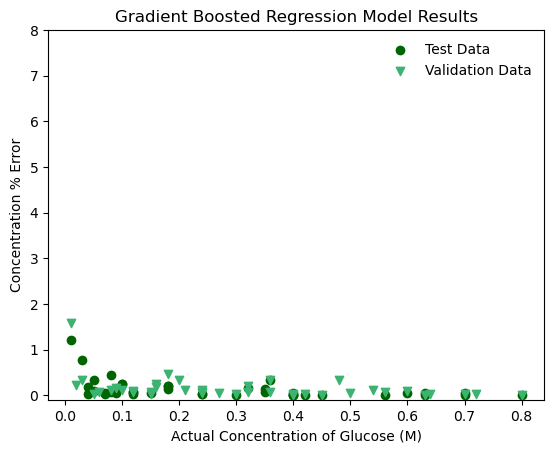

In [15]:
plt.scatter(val_results['Actual Validation Concentration'], val_results['Abs Difference %'], marker = 'o', color = 'darkgreen', label ='Test Data' )
plt.scatter(test_results['Actual Test Concentration'], test_results['Abs Difference %'], marker = 'v', color = 'mediumseagreen', label = 'Validation Data' )
plt.legend(frameon = False)
plt.title('Gradient Boosted Regression Model Results')
plt.ylabel('Concentration % Error')
plt.xlabel('Actual Concentration of Glucose (M)')
plt.ylim(-0.1,8)